# Setup

## Imports

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from gym import spaces
from scipy import stats

from recsim.environments import interest_evolution, interest_exploration, long_term_satisfaction
from recsim.agents import full_slate_q_agent, random_agent, slate_decomp_q_agent
from recsim.simulator import runner_lib
from recsim import document
from recsim import user
from recsim import agent
from recsim.choice_model import MultinomialLogitChoiceModel
from recsim.simulator import environment
from recsim.simulator import recsim_gym

2022-09-20 16:19:37.270926: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Configure TF1

In [2]:
tf.compat.v1.disable_eager_execution()

## Utility Functions

In [3]:
def get_event_file(dir_path):
    """
    Retrieves the tensorboard event file from specified dir
    """
    for f in os.listdir(dir_path):
        if f.startswith("events"):
            return os.path.join(dir_path, f)

def show_eval_results(base_dir, eval_dir_name, reward_name):
    """
    Display average episode reward during evaluation
    """
    eval_dir = os.path.join(base_dir, eval_dir_name)
    eval_event = get_event_file(eval_dir)
    for s in summary_iterator(eval_event):
        for v in s.summary.value:
            if v.tag.startswith("AverageEpisodeRewards"):
                print(f"Average episode {reward_name} in test: {v.simple_value}")

def show_training_results(base_dir, train_dir_name, reward_name):
    """
    Display average episode reward plot during training
    """
    train_dir = os.path.join(base_dir, train_dir_name)
    train_event = get_event_file(train_dir)
    reward_name = f"Average episode {reward_name}"
    df = pd.DataFrame(columns=[reward_name])
    for s in summary_iterator(train_event):
        for v in s.summary.value:
            if v.tag.startswith("AverageEpisodeRewards"):
                df = df.append({reward_name: v.simple_value}, ignore_index=True)
    df.plot(title=f"{reward_name} in training")

# Reinforcement Learning in Recommender Systems

## Why Reinforcement Learning?

Most practical recommender systems focus on estimating immediate user engagement without considering the long-term effects of recommendations on user behaviour. Reinforcement learning (RL) methods offer the potential to optimize recommendations for long-term user engagement. 

## Reinforcement Learning Overview

![reinforcement-learning-fig1-700.jpg](https://user-images.githubusercontent.com/25628862/191277765-29a2bab3-ed7d-4ffe-9918-3d773565f741.jpg)

Key components in a RL setup:
* Agent
* Environment
* State
* Action
* Reward

At each time step, the agent at state $s_t$ takes an action $a_t$, receives a reward $r_{t+1}$ from the environment and transitions into the next state $s_{t+1}$. The agent would leverage between exploration and exploitation to learn a optimal policy $\pi^*$ that maximizes the cumulative reward. 

The environment is typically modelled as a Markov Decision Process (MDP) with state space $S$, action space $A$, reward function $R$, and transition kernel $P$, with discount factor $0\leq\gamma\leq1$. The reward function $R(s,a)$ reflects the immediate reward of taking action $a$ in state $s$. The state transition probability $P(s\prime|s, a)$ indicates the probability that the agent transitions to state $s\prime$ when action $a$ is taken at state $s$. The discount factor is used to discount future rewards, a discount factor less than 1 indicates the distant future rewards are weighted less than immediate future rewards.

At each state $s$, the *Value function*, which is the value of the state following policy $\pi$ is given as:

$V^\pi(s) = r + \gamma\sum_{s\prime \in S}P(s\prime|s, \pi(s))V^\pi(s\prime)$

The corresponding action value, or *Q function*, which reflects the value of taking action $a$ at state $s$ following policy $\pi$ is given as:

$Q^\pi(s, a) = R(s, a) + \gamma\sum_{s\prime\in S}P(s\prime|s, a)V^\pi(s\prime)$

The *optimal policy* $\pi^*$ maximizes expected value $V(s)$ uniformly over $S$, which can be effectively represented this way:

$\pi^*(s) = argmax_{a\in A}Q^*(s, a)$

When transition and reward models are both provided, optimal policies and value functions can be computed using a variety of methods, though generally these require approximation in large state/action problems. With sampled data, RL method such as *Q-learning* can be used. Q-learning is a off-policy algorithm, meaning that the agent behavior policy during training is different than the learned policy. Q-learning employs $\epsilon-greedy$ policy during training, which encourages exploration during the early stage of training, and focuses on exploitation in the later stage. The Q function is updated in the following fashion:

$Q^{new}(s_t, a_t)$ &larr; $Q(s_t, a_t) + \alpha(r_t + \gamma \cdot max_{a_{t+1}}Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t))$ 

Where $\alpha$ is the learning rate.

## Slate Recommendation MDP model

Consider a setting in which a recommender system is charged with presenting a slate to a user, from which the user selects zero or more items for consumption (e.g., listening to selected music tracks, reading content, watching video content). Once items are consumed, the user can return for additional slate recommendations or terminate the session. The user’s response to a consumed item may have multiple dimensions. These may include the immediate degree of engagement with the item (e.g., consumption time); ratings feedback or comments; subsequent engagement with the content provider.

For our MDP model:
* The state space $S$ reflects *user state*, which includes relatively static user features (e.g., demographics, declared interests) and more dynamic user features (e.g., user context). Assume a finite state space for ease of exposition, although the methodology introduced later admit both countably infinite and continuous state features.
* The action space $A$ is the set of all possible recommendation slates. Assume a fixed catalog of recommendable items $I$, so actions are the subsets $a\subseteq I$ such that $|a| = k$, where $k$ is the slate size. In addition, assume that each item in $I$ and each slate $a$ is recommendable at each state $s$ for ease of exposition. However, the method introduced later apply readily when certain items cannot be recommended at particular states by specifying the recommendable subset and restricating slates to that subset. Positional bias or ordering effects are not accounted for in the following methodology, but one can incorporate these effects into the choice model. To account for when a user may not select an item from a recommended slate, assume every slate includes a $(k+1)$st null item.
* The transition probability $P(s\prime|s, a)$ generally reflects uncertainty in both user response and the future contextual or environmental state. One of the most critical points of uncertainty pertains the probability with which a user will consume a particular recommended item $a\in A$ from the slate. As such, choice models play a critical role in evaluating the quality of a slate, which will be detailed in a later section.
* The reward function $R$ captures the expected reward of a slate, which measures the expected degree of user engagement with items on the slate.


## SlateQ 

As mentioned above, RL methods offer the potential to optimize recommendations for long-term user engagement. However, since users are often presented with slates of multiple items—which may have interacting effects on user choice—methods are required to deal with the combinatorics of the RL action space.

Google’s SlateQ algorithm addresses this challenge by decomposing the long-term value (LTV) of a slate of items into a tractable function of its component item-wise LTVs. 

### Challenge & Difficulties
The key challenge in the MDP setup above is the combinatorial nature of the action space, consisting of all $\binom{|I|}{k}\cdot k!$ ordered $k$-sets over $I$, which poses three key difficulties:
* The size of action space makes sufficient *exploration* impractical.
* *Generalization* of Q-values across slates is challenging without some compressed representation.
* Must solve the combinatorial optimization problem of finding a slate with maximum Q-value


### Assumptions

SlateQ depends to some extent on the nature of the user choice model, but critically on the interaction it has with subsequent user behavior, specifically, how it influences both expected engagement (i.e., reward) and user latent state (i.e., state transition probabilities).

Two assumptions to derive the SlateQ decomposition:
* **Single choice (SC)**: A user consumes a *single* item from each slate (which may be the *null item*)
* **Reward/transition dependence on selection (RTDS)**: The realized reward (user engagement) $R(s, a)$ depends (perhaps stochastically) *only on the item $i \in a$ consumed by the user* (which may also be the *null item*). Similarly, the state transition $P(s\prime |s, a)$ depends only on the consumed $i \in a$.

Let $R(s, a, i)$ denote the reward when a user in state $s$, presented with slate $a$, selects item $i \in a$, and $P(s\prime |s, a, i)$ the corresponding probability of a transition to $s\prime$, the **SC** assumption allows us to express immediate rewards and state transitions as follows:

$R(s, a) = \sum_{i \in a}P(i|s, a)R(s, a, i)$

$P(s\prime |s, a) = \sum_{i \in a}P(i|s, a)P(s\prime |s, a, i)$

The **RTDS** assumption is typically the case that a user’s engagement with a selected item is not influenced to a great degree by the options in the slate that were not selected. This assumption can be stated as:

$R(s, a, i) = R(s, a\prime, i) = R(s, i),  \forall a, a\prime$ containing $i$

$P(s\prime |s, a, i) = P(s\prime |s, a\prime, i) = P(s\prime |s, i),  \forall a, a\prime$ containing $i$

### Solution for *Exploration* & *Generalization* 

The decomposition of Q-functions for a policy $\pi$ relies on an *item-wise auxiliary function* $\overline{Q^\pi}(s, i)$, which represents the LTV of a user consuming an item $i$. Under **RTDS**, this function is independent of the slate $a$ from which $i$ was selected. Define:

$\overline{Q^\pi}(s, i) = R(s, i) + \gamma \sum_{s\prime \in S}P(s\prime |s, i)V^\pi(s\prime)$

Incorporating the **SC** assumption, the Q-value can be written as:

$Q(s, a) = \sum_{i \in a}P(i |s, a)\overline{Q}(s, i)$

Plug this new Q-value expression into Q-Learning update rule:

$\overline{Q}(s, i)$ &larr; $\overline{Q}(s, i) + \alpha(r + \gamma \cdot max_{a\prime \in A}\sum_{j \in a\prime}P(j |s\prime, a\prime)\overline{Q}(s\prime, j) - \overline{Q}(s, i))$

The decomposition of Q-functions circumvents the natural combinatorics of both exploration and generalization.

### Solution for *Optimization*
Formulate the LTV slate optimization problem as follows:

$max_{a \subseteq I, |a| = k}\sum_{i \in a}P(i |s, a)\overline{Q}(s, i)$

This formulation can be solved using linear programming in polynomial time. Top-K and greedy optimizations can also be used to solve this in a shorter time with reduced gurantee of optimal solution.

# RecSim Overview

RecSim is a configurable platform for authoring simulation environments to allow both researchers and practitioners to challenge and extend existing reinforcement learning (RL) methods in synthetic recommender settings. 

![Detailed view of RecSim](https://user-images.githubusercontent.com/25628862/191278133-3f51eae8-a3bb-427c-8b26-56ef8f88a9da.png)

The green and blue blocks consititute the classes that need to be implemented within a RecSim environment

A single step of a RecSim simulation can be summarized roughly as follows:

1.   The document database provides a corpus of *D* documents to the recommender. In a fully observable situation, the recommender observes all features of each document that impact the user's state and choice of document, but this need not be the case in general. 
2.   The recommender observes the *D* documents (and their features) together with the user's response to the last recommendation. It then makes a selection of *k* documents and presents them to the user. The ordering may or may not impact the user choice or user state, depending on our simulation goals.
3.   The user examines the list of documents and makes a choice of one document. Note that not consuming any of the documents is also a valid choice. This leads to a transition in the user's state. Finally the user emits an observation, which the recommender observes at the next iteration. The observation generally includes (noisy) information about the user's reaction to the content and potentially clues about the user's latent state. Typically, the user's state is not fully revealed. 

## Environment
RecSim provides a set of ready-made simulation environments:
*   ```Interest Evolution```
*   ```Interest Exploration```
*   ```Long Term Satisfaction```

In this demo, we will use the ```Interest Evolution``` environment. This environment models the problem of active evolution of user interests. 

In this setting, documents are generated from *T* topics (types) such that each document belongs to exactly one topic. Each document has a inherent quality representing the topic-independent-attractiveness to the average user. On the other hand, each user has various degrees of interests in topics, ranging from -1 (completely uninterested) to 1 (fully interested). User *u*'s interest in document *d* is given by the dot product *I(u, d)* = $ud$. A user's satisfaction with a consumed document is a function of the user's interest and the document's quality. 


In [10]:
# Setting environment variables and sampling
np.random.seed(0)
env_config = {
  'num_candidates': 10,  # Number of docs to choose from
  'slate_size': 3,
  'resample_documents': True,
  'seed': 0,
  }
ie_environment = interest_exploration.create_environment(env_config)
initial_observation = ie_environment.reset()

## Observations
A RecSim observation is a dictionary with 3 keys:

* ```user```, which represent the 'User Observable Features' in the structure diagram above,
* ```doc```, containing the current corpus of recommendable videos and their observable features ('Document Observable Features'),
* ```response```, indicating the user's response to the last slate of recommendations ('User Response'). 

In [11]:
# Starting observations
print('User Observable Features')
print(initial_observation['user'])
print('User Response')
print(initial_observation['response'])
print('Document Observable Features')
for doc_id, doc_features in initial_observation['doc'].items():
  print('ID:', doc_id, 'features:', doc_features)

User Observable Features
[]
User Response
None
Document Observable Features
ID: 10 features: {'quality': array(2.02167129), 'cluster_id': 0}
ID: 11 features: {'quality': array(1.26831938), 'cluster_id': 1}
ID: 12 features: {'quality': array(1.04461702), 'cluster_id': 1}
ID: 13 features: {'quality': array(1.15411087), 'cluster_id': 1}
ID: 14 features: {'quality': array(1.18139301), 'cluster_id': 1}
ID: 15 features: {'quality': array(1.22720163), 'cluster_id': 1}
ID: 16 features: {'quality': array(1.29258489), 'cluster_id': 1}
ID: 17 features: {'quality': array(1.23977078), 'cluster_id': 1}
ID: 18 features: {'quality': array(1.46045555), 'cluster_id': 1}
ID: 19 features: {'quality': array(2.10233425), 'cluster_id': 0}


## Create Agents



In [6]:
def create_slate_decomp_q_agent(sess, environment, summary_writer, eval_mode):
    """
    A variant of the SlateQ learning agent that is based on Q-learning, and uses 
    linear programming for optimization both at training time and serving time 
    """
    kwargs = {
        'observation_space': environment.observation_space,
        'action_space': environment.action_space,
        'summary_writer': summary_writer,
        'eval_mode': eval_mode,
    }
    return slate_decomp_q_agent.create_agent(agent_name='slate_optimal_optimal_q', 
                                             sess=sess, 
                                             **kwargs)

def create_full_slate_q_agent(sess, environment, summary_writer, eval_mode):
    """
    A standard, non-decomposed Q-learning agent that treats each slate atomically
    as a single action
    """
    kwargs = {
        'observation_space': environment.observation_space,
        'action_space': environment.action_space,
        'summary_writer': summary_writer,
        'eval_mode': eval_mode,
    }
    return full_slate_q_agent.FullSlateQAgent(sess, **kwargs)

def create_random_agent(sess, environment, summary_writer, eval_mode):
    """
    An agent that recommends a random slate of documents
    """
    kwargs = {
        'action_space': environment.action_space,
    }
    return random_agent.RandomAgent(**kwargs)


## Training and Evaluation

### SlateQ

In [12]:
%rm -rf ./results/slate_decomp

In [15]:
tmp_slate_decomp_dir = './results/slate_decomp/'

#### Training

In [ ]:
slate_decomp_train_runner = runner_lib.TrainRunner(
    base_dir=tmp_slate_decomp_dir,
    create_agent_fn=create_slate_decomp_q_agent,
    env=interest_evolution.create_environment(env_config),
    episode_log_file="",
    max_training_steps=50,
    num_iterations=50)
slate_decomp_train_runner.run_experiment()

#### Evaluation

In [ ]:
slate_decomp_eval_runner = runner_lib.EvalRunner(
    base_dir=tmp_slate_decomp_dir,
    create_agent_fn=create_slate_decomp_q_agent,
    env=interest_evolution.create_environment(env_config),
    max_eval_episodes=10,
    test_mode=True)
slate_decomp_eval_runner.run_experiment()

#### Visualization

Average episode clicked watch time in test: 159.09039306640625


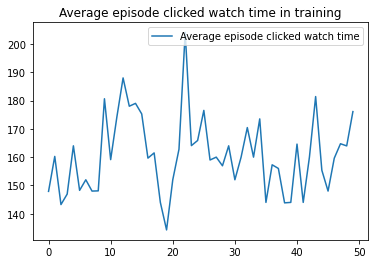

In [46]:
slate_decomp_agent_dir = os.listdir(tmp_slate_decomp_dir)
slate_decomp_agent_dir.sort(reverse=True)
show_training_results(tmp_slate_decomp_dir, slate_decomp_agent_dir[0], "clicked watch time")
show_eval_results(tmp_slate_decomp_dir, slate_decomp_agent_dir[1], "clicked watch time")

### Full Slate Q Learning

In [19]:
%rm -rf ./results/full_slate_q

In [20]:
tmp_full_slate_q_dir = './results/full_slate_q/'

#### Training

In [ ]:
full_slate_q_train_runner = runner_lib.TrainRunner(
    base_dir=tmp_full_slate_q_dir,
    create_agent_fn=create_full_slate_q_agent,
    env=interest_evolution.create_environment(env_config),
    episode_log_file="",
    max_training_steps=50,
    num_iterations=50)
full_slate_q_train_runner.run_experiment()

#### Evaluation

In [ ]:
full_slate_q_eval_runner = runner_lib.EvalRunner(
    base_dir=tmp_full_slate_q_dir,
    create_agent_fn=create_full_slate_q_agent,
    env=interest_evolution.create_environment(env_config),
    max_eval_episodes=10,
    test_mode=True)
full_slate_q_eval_runner.run_experiment()

#### Visualization

Average episode total number of clicks in test: 157.3602294921875


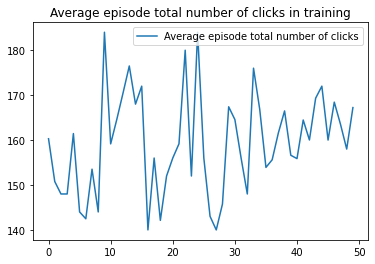

In [23]:
full_slate_q_agent_dir = os.listdir(tmp_full_slate_q_dir)
full_slate_q_agent_dir.sort(reverse=True)
show_training_results(tmp_full_slate_q_dir, full_slate_q_agent_dir[0], "total number of clicks")
show_eval_results(tmp_full_slate_q_dir, full_slate_q_agent_dir[1], "total number of clicks")

### Random

In [ ]:
%rm -rf ./results/random

In [24]:
tmp_random_dir = './results/random/'

#### Training

In [ ]:
random_train_runner = runner_lib.TrainRunner(
    base_dir=tmp_random_dir,
    create_agent_fn=create_random_agent,
    env=interest_evolution.create_environment(env_config),
    episode_log_file="",
    max_training_steps=50,
    num_iterations=50)
random_train_runner.run_experiment()

#### Evaluation

In [ ]:
random_eval_runner = runner_lib.EvalRunner(
    base_dir=tmp_random_dir,
    create_agent_fn=create_random_agent,
    env=interest_evolution.create_environment(env_config),
    max_eval_episodes=10,
    test_mode=True)
random_eval_runner.run_experiment()

#### Visualization

Average episode total number of clicks in test: 154.5304412841797


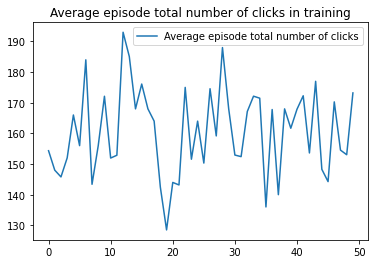

In [27]:
random_agent_dir = os.listdir(tmp_random_dir)
random_agent_dir.sort(reverse=True)
show_training_results(tmp_random_dir, random_agent_dir[0], "total number of clicks")
show_eval_results(tmp_random_dir, random_agent_dir[1], "total number of clicks")

# Customize RecSim Environment

This customized environment depicts a situation in which a user of an online service interacts with items of content, which are characterized by their level of clickbaitiness (on a scale of 0 to 1). We'll refer to clickbaity items as choclate, and non-clickbaity items as kale. In particular, clickbaity items (choclatey) generate engagement, but lead to decrease in long-term satisfaction. Non-clickbaity items (kaley) increase satisfaction but do not generate as much engagement. 

A user's latent state consists of a 1-dimensional *satisfaction* variable. Each time a more "kaley" document is consumed, that variable tends to increase, and conversely, a chocolatey document tends to decrease satisfaction. Upon consumption of a document, the user emits some (stochastic) measure of engagement (say, the watch-time of a video). The magnitude of the expected engagement is proportional to the user's satisfaction and inversely proportional to the kaleness of the video.

The goal is to balance the two in order to achieve some long-term optimal trade-off.

## Document Model
The RecSim document model requires the following components
* a document template 
* a document sampler

### Document Template
A RecSim document template serves as the main unit of exchange between the document model, agent, and user. A document class implementation is essentially a container for the unobservable and observable features of the underlying document. The base class requires the implementation of an observation_space() static method, declaring the format of the document observable features as an OpenAI gym space, and a create_observation function, which returns a realization of said space. Also, each document must have a unique integer ID.

In our case, documents have only one feature, which is their kaleness value, represented as a 1-dimensional spaces.Box (i.e., numpy array of size 1).

In [28]:
class LTSDocument(document.AbstractDocument):
  def __init__(self, doc_id, kaleness):
    self.kaleness = kaleness
    super(LTSDocument, self).__init__(doc_id)

  def create_observation(self):
    return np.array([self.kaleness])

  @staticmethod
  def observation_space():
    return spaces.Box(shape=(1,), dtype=np.float32, low=0.0, high=1.0)
  
  def __str__(self):
    return "Document {} with kaleness {}.".format(self._doc_id, self.kaleness)

### Document Sampler
A document sampler is a generative distribution for documents, which will get invoked to regenerate the corpus either after every step or after every session (depending on runner_lib settings). The sample_document() function is required by the base class. It must return a document sampled from our desired distribution. 

In our case, it returns a document with a kaleness score sampled from a uniform distribution.

In [29]:
class LTSDocumentSampler(document.AbstractDocumentSampler):
  def __init__(self, doc_ctor=LTSDocument, **kwargs):
    super(LTSDocumentSampler, self).__init__(doc_ctor, **kwargs)
    self._doc_count = 0

  def sample_document(self):
    doc_features = {}
    doc_features['doc_id'] = self._doc_count
    doc_features['kaleness'] = self._rng.random_sample()
    self._doc_count += 1
    return self._doc_ctor(**doc_features)

Now we can simulate documents

In [30]:
sampler = LTSDocumentSampler()
for i in range(5): print(sampler.sample_document())
d = sampler.sample_document()
print("Documents have observation space:", d.observation_space(), "\n"
      "An example realization is: ", d.create_observation())

Document 0 with kaleness 0.5488135039273248.
Document 1 with kaleness 0.7151893663724195.
Document 2 with kaleness 0.6027633760716439.
Document 3 with kaleness 0.5448831829968969.
Document 4 with kaleness 0.4236547993389047.
Documents have observation space: Box(0.0, 1.0, (1,), float32) 
An example realization is:  [0.64589411]


## User Model
The RecSim user model requires the following components:
* a user state
* a user sampler (a distribution over the starting state of users) 
* a user state transition model
* a user response

The user model for this demo is inpired by the tutorial from the RecSim repo, which defines the user engagement dynamics, the details are as follows:
* each user has a feature called net kale exposure ($\text{nke}_t$), and satisfaction ($\text{sat}_t$). They are related via the logistic function to reflect the fact that satisfaction cannot be unbounded. Namely,
$$\text{sat}_t = \sigma(\tau\cdot\text{nke}_t),$$
where $\tau$ is a user-specific sensitivity parameter. Satisfaction and net kale exposure are bijectively related to each other, so only one is needed to keep track of state.
* Given a slate $S$, the user chooses an item based on a multinomial logit choice model with the items' chocolateness as features: $p(\text{user chooses }d_i \text{ from slate }S) \sim e^{1-\mathrm{kaleness}(d_i)}$ (since chocolatey documents are more clicky).
* Once the user chooses a document, the net kale exposure evolves as
$$\text{nke}_{t+1} = \beta \cdot \text{nke}_t + 2(k_d - 1/2) + {\cal N}(0, \eta),$$
where $\beta$ is some user-specific memory discount (forgetting factor), $k_d$ is the kaleness of the chosen document and $\eta$ is some noise standard deviation. 
* Finally, the user engages with the chosen content for $s_d$ seconds, where $s_d$ is drawn according to
$$s_d\sim\log{\cal N}(k_d\mu_k + (1-k_d)\mu_c, k_d\sigma_k + (1-k_d)\sigma_c),$$
i.e. a log-normal distribution with parameters linearly interpolating between the pure kale response $(\mu_k, \sigma_k)$ and the pure choc response $(\mu_c, \sigma_c)$.

Thus, a user state is defined by the tuple $(\text{sat}, \tau, \beta, \eta, \mu_k, \sigma_k, \mu_c, \sigma_c).$ The satisfaction variable is the only dynamic part of the state, whereas the other parameters define the user and are static. 


### User State
observation_space() and create_observations() are required for AbstractUserState class. These are used to feed partial (or complete) information about the user's state to the agent at every iteration.

In [31]:
class LTSUserState(user.AbstractUserState):
    def __init__(self, memory_discount, sensitivity, innovation_stddev,
                choc_mean, choc_stddev, kale_mean, kale_stddev,
                net_kaleness_exposure, time_budget, observation_noise_stddev=0.1
                ):
        # Transition model parameters
        self.memory_discount = memory_discount
        self.sensitivity = sensitivity
        self.innovation_stddev = innovation_stddev

        # Engagement parameters
        self.choc_mean = choc_mean
        self.choc_stddev = choc_stddev
        self.kale_mean = kale_mean
        self.kale_stddev = kale_stddev

        # State variables
        self.net_kaleness_exposure = net_kaleness_exposure
        self.satisfaction = 1 / (1 + np.exp(-sensitivity * net_kaleness_exposure))
        self.time_budget = time_budget

        # Noise
        self._observation_noise = observation_noise_stddev

    def create_observation(self):
        """
        User's state is not observable.
        """
        clip_low, clip_high = (-1.0 / (1.0 * self._observation_noise),
                            1.0 / (1.0 * self._observation_noise))
        noise = stats.truncnorm(
            clip_low, clip_high, loc=0.0, scale=self._observation_noise).rvs()
        noisy_sat = self.satisfaction + noise
        return np.array([noisy_sat,])

    @staticmethod
    def observation_space():
        return spaces.Box(shape=(1,), dtype=np.float32, low=-2.0, high=2.0)
    
    def score_document(self, doc_obs):
        """
        Scoring function for use in the choice model -- the user is more likely 
        to click on more chocolatey content.
        """
        return 1 - doc_obs

### User Sampler
The User sampler is a generative distribution of the user starting states, which sets the starting user state for every session. For this demo, we will just sample the starting $\text{nke}_0$ and keep all the static parameters the same, meaning that we essentially deal with the same user at different levels of satisfaction.

Sampling code has to be implemented in sample_user(), as required by the base class.

In [32]:
class LTSStaticUserSampler(user.AbstractUserSampler):
  _state_parameters = None

  def __init__(self,
               user_ctor=LTSUserState,
               memory_discount=0.9,
               sensitivity=0.01,
               innovation_stddev=0.05,
               choc_mean=5.0,
               choc_stddev=1.0,
               kale_mean=4.0,
               kale_stddev=1.0,
               time_budget=60,
               **kwargs):
    self._state_parameters = {'memory_discount': memory_discount,
                              'sensitivity': sensitivity,
                              'innovation_stddev': innovation_stddev,
                              'choc_mean': choc_mean,
                              'choc_stddev': choc_stddev,
                              'kale_mean': kale_mean,
                              'kale_stddev': kale_stddev,
                              'time_budget': time_budget
                             }
    super(LTSStaticUserSampler, self).__init__(user_ctor, **kwargs)

  def sample_user(self):
    starting_nke = ((self._rng.random_sample() - .5) *
                    (1 / (1.0 - self._state_parameters['memory_discount'])))
    self._state_parameters['net_kaleness_exposure'] = starting_nke
    return self._user_ctor(**self._state_parameters)

Now we can simulate user starting states

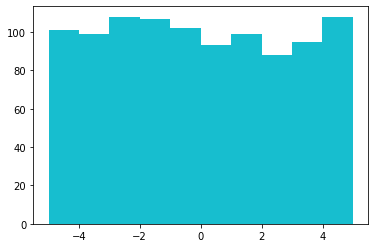

In [33]:
sampler = LTSStaticUserSampler()
starting_nke = []
for i in range(1000):
    sampled_user = sampler.sample_user()
    starting_nke.append(sampled_user.net_kaleness_exposure)
    plt.hist(starting_nke)

### Response Model
RecSim will generate one response for every recommended item in the slate. The contents of the response are what the agent will see as document-specific feedback from the recommendation.

In [34]:
class LTSResponse(user.AbstractResponse):
  # The maximum degree of engagement.
  MAX_ENGAGEMENT_MAGNITUDE = 100.0

  def __init__(self, clicked=False, engagement=0.0):
    self.clicked = clicked
    self.engagement = engagement

  def create_observation(self):
    return {'click': int(self.clicked), 'engagement': np.array(self.engagement)}

  @classmethod
  def response_space(cls):
    # `engagement` feature range is [0, MAX_ENGAGEMENT_MAGNITUDE]
    return spaces.Dict({
        'click':
            spaces.Discrete(2),
        'engagement':
            spaces.Box(
                low=0.0,
                high=cls.MAX_ENGAGEMENT_MAGNITUDE,
                shape=tuple(),
                dtype=np.float32)
    })

### User State Transition Model
A RecSim user model (deriving from recsim.user.AbstractUserModel) is responsible for 
* maintaining user state, 
* evolving user state as a result of recommendations,
* generating a response to a slate of recommendations.

The user model is required by the base class to implement update_state(), simulate_response(), and is_terminal(). 

In [35]:
class LTSUserModel(user.AbstractUserModel):
    def __init__(self, slate_size, seed=0):
        super().__init__(
            LTSResponse, 
            LTSStaticUserSampler(LTSUserState, seed=seed), 
            slate_size)
        self.choice_model = MultinomialLogitChoiceModel({})

    def simulate_response(self, slate_documents):
        """
        Takes in a slate (list) of recommended LTSDocuments and must output a 
        slate of user responses. The k-th response in the slate of responses 
        corresponds to the k-th document in the recommendation slate
        """
        # List of empty responses
        responses = [self._response_model_ctor() for _ in slate_documents]
        # Get click from of choice model.
        self.choice_model.score_documents(
            self._user_state, [doc.create_observation() for doc in slate_documents])
        scores = self.choice_model.scores
        selected_index = self.choice_model.choose_item()
        # Populate clicked item.
        self._generate_response(slate_documents[selected_index],
                                responses[selected_index])
        return responses

    def _generate_response(self, doc, response):
        response.clicked = True
        # linear interpolation between choc and kale.
        engagement_loc = (doc.kaleness * self._user_state.choc_mean
                            + (1 - doc.kaleness) * self._user_state.kale_mean)
        engagement_loc *= self._user_state.satisfaction
        engagement_scale = (doc.kaleness * self._user_state.choc_stddev
                            + ((1 - doc.kaleness)
                                * self._user_state.kale_stddev))
        log_engagement = np.random.normal(loc=engagement_loc,
                                            scale=engagement_scale)
        response.engagement = np.exp(log_engagement)

    def update_state(self, slate_documents, responses):
        """
        Consumes the recommended slate, as well as the actual choices (responses) 
        to induce a state transition
        """
        for doc, response in zip(slate_documents, responses):
            if response.clicked:
                innovation = np.random.normal(scale=self._user_state.innovation_stddev)
                net_kaleness_exposure = (self._user_state.memory_discount
                                            * self._user_state.net_kaleness_exposure
                                            - 2.0 * (doc.kaleness - 0.5)
                                            + innovation
                                        )
                self._user_state.net_kaleness_exposure = net_kaleness_exposure
                satisfaction = 1 / (1.0 + np.exp(-self._user_state.sensitivity
                                                    * net_kaleness_exposure)
                                    )
                self._user_state.satisfaction = satisfaction
                self._user_state.time_budget -= 1
                return

    def is_terminal(self):
        """
        Returns a boolean indicating if the session is over.
        """
        return self._user_state.time_budget <= 0

## Reward Function

To complete the RL environment, we also need a reward function. In RecSim, the reward function maps a set of responses to a real number. Since this environment is designed to maximize long term user satisfaction, let's set the reward function to the engagement time of the clicked documents.

In [36]:
def clicked_engagement_reward(responses):
    """
    Calculates the total clicked watchtime from a list of responses
    """
    reward = 0
    for response in responses:
        if response.clicked:
            reward += response.engagement
    return reward

## Customized Environment
We now have defined all the components needed for a customized environment

In [37]:
def create_customized_env(env_config):
    """
    Creates the customized environment
    """
    lts_environment = environment.SingleUserEnvironment(
        LTSUserModel(
            env_config["slate_size"], 
            env_config["seed"]),
        LTSDocumentSampler(),
        env_config["num_candidates"],
        env_config["slate_size"],
        resample_documents=env_config["resample_documents"])
    return recsim_gym.RecSimGymEnv(lts_environment, clicked_engagement_reward)

### Observations

In [38]:
env_config = {
  'num_candidates': 10,  # Number of docs to choose from
  'slate_size': 3,
  'resample_documents': True,
  'seed': 0,
  }

In [39]:
lts_gym_env = create_customized_env(env_config)
initial_observation = lts_gym_env.reset()

In [40]:
print('User Observable Features')
print(initial_observation['user'])
print('User Response')
print(initial_observation['response'])
print('Document Observable Features')
for doc_id, doc_features in initial_observation['doc'].items():
  print('ID:', doc_id, 'features:', doc_features)

User Observable Features
[0.43092451]
User Response
None
Document Observable Features
ID: 10 features: [0.79172504]
ID: 11 features: [0.52889492]
ID: 12 features: [0.56804456]
ID: 13 features: [0.92559664]
ID: 14 features: [0.07103606]
ID: 15 features: [0.0871293]
ID: 16 features: [0.0202184]
ID: 17 features: [0.83261985]
ID: 18 features: [0.77815675]
ID: 19 features: [0.87001215]


In [41]:
print('Observation 0')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in initial_observation['doc'].items()]
print('\n'.join(doc_strings))
print('Noisy user state observation')
print(initial_observation['user'])
# Agent recommends the first three documents.
recommendation_slate_0 = [0, 1, 2]
observation_1, reward, done, _ = lts_gym_env.step(recommendation_slate_0)
print('Observation 1')
print('Available documents')
doc_strings = ['doc_id ' + key + " kaleness " + str(value) for key, value
               in observation_1['doc'].items()]
print('\n'.join(doc_strings))
rsp_strings = [str(response) for response in observation_1['response']]
print('User responses to documents in the slate')
print('\n'.join(rsp_strings))
print('Noisy user state observation')
print(observation_1['user'])

Observation 0
Available documents
doc_id 10 kaleness [0.79172504]
doc_id 11 kaleness [0.52889492]
doc_id 12 kaleness [0.56804456]
doc_id 13 kaleness [0.92559664]
doc_id 14 kaleness [0.07103606]
doc_id 15 kaleness [0.0871293]
doc_id 16 kaleness [0.0202184]
doc_id 17 kaleness [0.83261985]
doc_id 18 kaleness [0.77815675]
doc_id 19 kaleness [0.87001215]
Noisy user state observation
[0.43092451]
Observation 1
Available documents
doc_id 20 kaleness [0.97861834]
doc_id 21 kaleness [0.79915856]
doc_id 22 kaleness [0.46147936]
doc_id 23 kaleness [0.78052918]
doc_id 24 kaleness [0.11827443]
doc_id 25 kaleness [0.63992102]
doc_id 26 kaleness [0.14335329]
doc_id 27 kaleness [0.94466892]
doc_id 28 kaleness [0.52184832]
doc_id 29 kaleness [0.41466194]
User responses to documents in the slate
{'click': 1, 'engagement': array(10.14002554)}
{'click': 0, 'engagement': array(0.)}
{'click': 0, 'engagement': array(0.)}
Noisy user state observation
[0.50000291]


### Train and Evaluate a SlateQ Agent 

In [42]:
%rm -rf ./results/custom_env/
tmp_custom_env_dir = './results/custom_env/'

#### Training

In [ ]:
runner = runner_lib.TrainRunner(
    base_dir=tmp_custom_env_dir,
    create_agent_fn=create_full_slate_q_agent,
    env=create_customized_env(env_config),
    episode_log_file="",
    max_training_steps=50,
    num_iterations=50)
runner.run_experiment()

#### Evaluation

In [ ]:
runner = runner_lib.EvalRunner(
    base_dir=tmp_custom_env_dir,
    create_agent_fn=create_full_slate_q_agent,
    env=create_customized_env(env_config),
    max_eval_episodes=10,
    test_mode=True)
runner.run_experiment()

#### Visualization

Average episode clicked watch time in test: 923.5245971679688


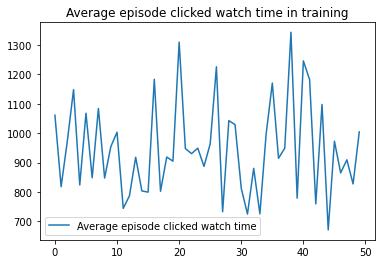

In [45]:
slate_q_custom_env_agent_dir = os.listdir(tmp_custom_env_dir)
slate_q_custom_env_agent_dir.sort()
show_training_results(tmp_custom_env_dir, slate_q_custom_env_agent_dir[1], "clicked watch time")
show_eval_results(tmp_custom_env_dir, slate_q_custom_env_agent_dir[0], "clicked watch time")